In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, max_error

In [25]:
# Feature Selectiom
# Load the datasets
train_val = pd.read_csv('1920.csv')
train_val_dataset = pd.DataFrame(train_val)
test = pd.read_csv('2021.csv')
test_dataset = pd.DataFrame(test)

# Extract X and y
X_keys = [c for c in test_dataset.columns if (c != 'WS' and 'Name' not in c and 'WS/48' not in c)]

X_train_val = train_val[X_keys].values
X_train = train_val[X_keys].values[:-77]
X_val = train_val[X_keys].values[-77:]
X_test = test[X_keys].values
y_train_val = train_val['WS'].values
y_train = train_val['WS'].values[:-77]
y_val = train_val['WS'].values[-77:]
y_test = test['WS'].values

In [26]:
# Fit models and select features using MAE
feature_indices = list(range(X_train.shape[1]))
max_feature = 8
first_n = 10

# The models are evaluated through coefficient of determination
score_list = []
current_feature_list = [[]]
feature_list = []

# Iterate when the feature number did not reach the limit
while len(current_feature_list[0]) != 8:
    new_feature_sets = []
    
    temp_scores = []
    for current_features in current_feature_list:
        remaining_features = [feature for feature in range(X_train.shape[1]) if feature not in current_features]
        for new_feature in remaining_features:
            # Append the feature to the list if the set is new
            temp = current_features.copy()
            temp.extend([new_feature])
            temp.sort()
            if temp not in new_feature_sets:
                new_feature_sets.append(temp)
            else:
                continue
            
            # Fit the model
            linear = LinearRegression().fit(X_train[:, temp], y_train)
            score = linear.score(X_val[:, temp], y_val)
            temp_scores.append(score)
            
    # Get the best feature sets
    sorted_indices = np.argsort(temp_scores)[::-1][:first_n]
    sorted_indices.sort()
    best_featuresets = np.array(new_feature_sets)[sorted_indices].tolist()
    
    # Append the sets
    score_list.extend(np.array(temp_scores)[sorted_indices].tolist())
    feature_list.extend(best_featuresets)
    current_feature_list = best_featuresets.copy()

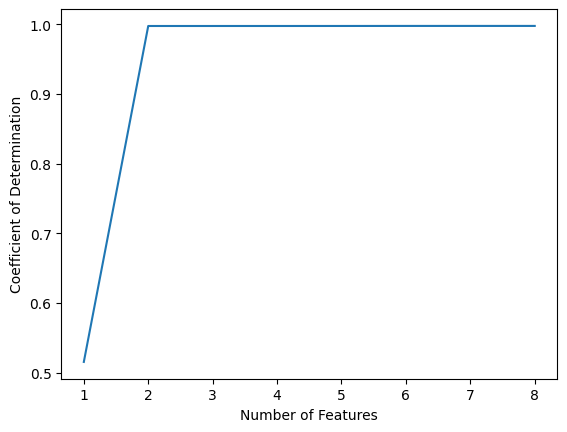

The features chosen by our algorithm are: 
['MP' '3PAr' 'ORB%' 'AST%' 'USG%' 'OWS' 'DWS']


In [27]:
# Visualize the highest scores in each set
plt.figure()
max_scores = []
for i in range(max_feature):
    scores = score_list[i*10:(i+1)*10]
    max_scores.append(max(scores))
    
plt.plot(np.arange(max_feature)+1, max_scores)
plt.xlabel("Number of Features")
plt.ylabel("Coefficient of Determination")
plt.show()

# We can see a good performance can be obtained when the number of features is 2, but we shall pick the set with the highest score
index = np.argmax(score_list)
feature_set = feature_list[index]

# Print the features
print("The features chosen by our algorithm are: ")
print(np.array(X_keys)[feature_set])

In [28]:
# The baseline classifier could be a linear model fit on the entire dataset
result_dict = {}
baseline = LinearRegression().fit(X_train_val[:, feature_set], y_train_val)

# Evaluate the model through: 1. MAE 2. the coefficient of determination 3. max error
print("Evaluating the baseline model...")
y_pred = baseline.predict(X_test[:, feature_set])
mae = mean_absolute_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
maxerror = max_error(y_test, y_pred)

print("MAE=%.6f, R**2=%.6f, Max Error=%.6f"%(mae, r_square, maxerror))
result_dict['Baseline'] = {'MAE':mae, 'R Square': r_square, 'Max Error': maxerror}

Evaluating the baseline model...
MAE=0.026944, R**2=0.999596, Max Error=0.116172


In [29]:
# SVM (very coarse grained for regression)
svm_regressor = SVR().fit(X_train_val[:, feature_set], y_train_val)
print("Evaluating the SVM...")
y_pred = svm_regressor.predict(X_test[:, feature_set])
mae = mean_absolute_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
maxerror = max_error(y_test, y_pred)
result_dict['SVM'] = {'MAE':mae, 'R Square': r_square, 'Max Error': maxerror}

# Ridge regressor (not very useful when the good features are already selected)
ridge = Ridge().fit(X_train_val[:, feature_set], y_train_val)
print("Evaluating the ridge regressor...")
y_pred = ridge.predict(X_test[:, feature_set])
mae = mean_absolute_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
maxerror = max_error(y_test, y_pred)
result_dict['Ridge'] = {'MAE':mae, 'R Square': r_square, 'Max Error': maxerror}

# MLPRegressor (varies a lot when changing hyper-parameters such as hidden layer sizes)
mlp = MLPRegressor(hidden_layer_sizes=(256, 64), batch_size=32, random_state=0, learning_rate='adaptive', max_iter=1000).fit(X_train_val[:, feature_set], y_train_val)
print("Evaluating the MLP model...")
y_pred = mlp.predict(X_test[:, feature_set])
mae = mean_absolute_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
maxerror = max_error(y_test, y_pred)
result_dict['MLP'] = {'MAE':mae, 'R Square': r_square, 'Max Error': maxerror}

# Make a table
df = pd.DataFrame(result_dict)
df

Evaluating the SVM...
Evaluating the ridge regressor...
Evaluating the MLP model...


,Baseline,SVM,Ridge,MLP
MAE,0.026944,1.067441,0.028018,0.160540
R Square,0.999596,0.525149,0.999589,0.992521
Max Error,0.116172,9.866247,0.121597,0.832651
